ENVIRONMENT : VENVNEW

In [1]:
!pip install opencv-python

The code below is for pseudo segmentation,  let me explain how :-

(1) We have made a folder pseudo dataset inside which we have made 2 subfolders namely : Images and Mask

(2) Now our dataset folder contained classes of tumors in train, tet and val, and inside these classes there were images.

(3) First of all we obtained a complete class path consisting of class of tumor.

(4) After that, we obtained image path of all images under each classes.

(5) The images were then converted into gray scale and then resized so that it can be applied to model easily.

(6) In Otsu threshold, we applied the technique that if pixel value is more than T it will be converted to white (22)and if it is less than T it will be converted to black (0) where T is a threshold value.

(7) After this noise was removed, gaps were filled and it was ensured that image should be of binary form (i.e either black or white)

(8) In this way pseudo masks were generated.


In [ ]:
import cv2
import os
import numpy as np

IMAGE_DIR = r"C:\Users\aryan\OneDrive\Desktop\DLPROJECT\dataset\train"
OUT_IMG_DIR = r"C:\Users\aryan\OneDrive\Desktop\DLPROJECT\pseudo_dataset\images"
OUT_MASK_DIR = r"C:\Users\aryan\OneDrive\Desktop\DLPROJECT\pseudo_dataset\masks"

os.makedirs(OUT_IMG_DIR, exist_ok=True)
os.makedirs(OUT_MASK_DIR, exist_ok=True)

for class_name in os.listdir(IMAGE_DIR):
    class_path = os.path.join(IMAGE_DIR, class_name)

    if not os.path.isdir(class_path):
        continue

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        img = cv2.resize(img, (224, 224))

        # Otsu threshold
        _, mask = cv2.threshold(
            img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )

        # Morphological cleanup
        kernel = np.ones((5,5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        #forced binary segmentation
        mask = np.where(mask > 127, 255, 0).astype(np.uint8)

        # Save
        cv2.imwrite(os.path.join(OUT_IMG_DIR, img_name), img)
        cv2.imwrite(os.path.join(OUT_MASK_DIR, img_name), mask)

print("✅ Pseudo masks generated")


✅ Pseudo masks generated


In [ ]:
#To check length of images and masks and ensure that they are equal because it is necessary that for each image, a mask should get obtained

imgs = set(os.listdir(OUT_IMG_DIR))
masks = set(os.listdir(OUT_MASK_DIR))

print("Images:", len(imgs))
print("Masks :", len(masks))
print("Paired:", imgs == masks)


Images: 2966
Masks : 2966
Paired: True


In [4]:
sample_mask = cv2.imread(
    os.path.join(OUT_MASK_DIR, os.listdir(OUT_MASK_DIR)[0]),
    cv2.IMREAD_GRAYSCALE
)

print("Mask shape:", sample_mask.shape)
print("Unique values:", np.unique(sample_mask))


Mask shape: (224, 224)
Unique values: [  0   1   2   3   4   5   6   7 248 249 250 251 252 253 254 255]


In the code below we have made sure that value should stay either 0 or 255 that is we need images to be in a binary fashion so that the dice function can behave propely and proper segmentation could happen.

In [5]:
import cv2
import numpy as np

img = cv2.imread(
    r"C:\Users\aryan\OneDrive\Desktop\DLPROJECT\dataset\train"
    + "\\" + os.listdir(r"C:\Users\aryan\OneDrive\Desktop\DLPROJECT\dataset\train")[0]
    + "\\" + os.listdir(
        r"C:\Users\aryan\OneDrive\Desktop\DLPROJECT\dataset\train"
        + "\\" + os.listdir(r"C:\Users\aryan\OneDrive\Desktop\DLPROJECT\dataset\train")[0]
    )[0],
    cv2.IMREAD_GRAYSCALE
)

img = cv2.resize(img, (224,224))

_, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
mask = np.where(mask > 127, 255, 0).astype(np.uint8)

print("IN-MEMORY UNIQUE:", np.unique(mask))


IN-MEMORY UNIQUE: [  0 255]


In [6]:
cv2.imwrite("debug_mask.png", mask)

reloaded = cv2.imread("debug_mask.png", cv2.IMREAD_GRAYSCALE)
print("RELOADED UNIQUE:", np.unique(reloaded))


RELOADED UNIQUE: [  0 255]


In this code below we have chosen a random pair of image and mask for which we have generated its actual image, its mask made by us and we have overlaid both of them to make sure that image and its masks are accurate and perfectly aligned.

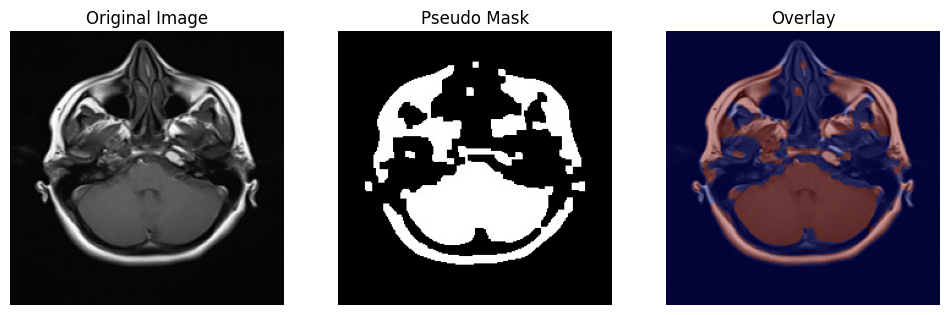

In [7]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

IMG_DIR = r"C:\Users\aryan\OneDrive\Desktop\DLPROJECT\pseudo_dataset\images"
MASK_DIR = r"C:\Users\aryan\OneDrive\Desktop\DLPROJECT\pseudo_dataset\masks"

# Pick a sample image (you can change the index)
fname = sorted(os.listdir(IMG_DIR))[10]

img = cv2.imread(os.path.join(IMG_DIR, fname), cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(os.path.join(MASK_DIR, fname), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Pseudo Mask")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(img, cmap="gray")
plt.imshow(mask, cmap="jet", alpha=0.4)
plt.axis("off")

plt.show()


DATASET PREPARATION

In [8]:
!pip install torch torchvision torchaudio
!pip install monai
!pip install matplotlib opencv-python


   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.7 MB 8.5 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 12.9 MB/s  0:00:00


In [9]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [10]:
class BrainTumorSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]

        # Load image
        img_path = os.path.join(self.image_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224, 224))

        # Normalize image
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0)  # (1, H, W)

        # Load mask
        mask_path = os.path.join(self.mask_dir, img_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (224, 224))

        # Convert mask to binary (0,1)
        mask = (mask > 127).astype(np.float32)

        return torch.tensor(img), torch.tensor(mask)


In [11]:
IMG_DIR = r"C:\Users\aryan\OneDrive\Desktop\DLPROJECT\pseudo_dataset\images"
MASK_DIR = r"C:\Users\aryan\OneDrive\Desktop\DLPROJECT\pseudo_dataset\masks"

dataset = BrainTumorSegDataset(IMG_DIR, MASK_DIR)

loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0
)


In [12]:
imgs, masks = next(iter(loader))

print("Image batch shape:", imgs.shape)
print("Mask batch shape:", masks.shape)
print("Unique mask values:", torch.unique(masks))


Image batch shape: torch.Size([4, 1, 224, 224])
Mask batch shape: torch.Size([4, 224, 224])
Unique mask values: tensor([0., 1.])


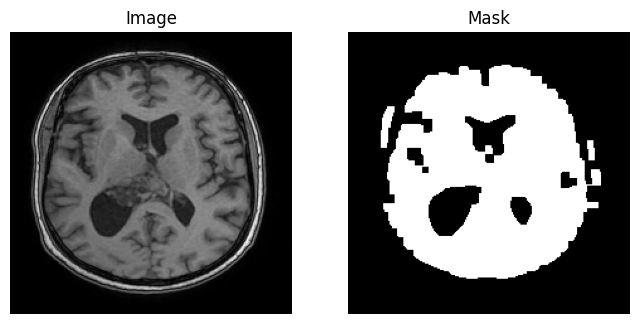

In [13]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.title("Image")
plt.imshow(imgs[0][0], cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(masks[0], cmap="gray")
plt.axis("off")

plt.show()


In [19]:
import monai
print(monai.__version__)


1.5.1


In [29]:
from monai.networks.nets import ViT
import torch.nn as nn
!pip install einops


In [33]:
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.transforms import Compose, ScaleIntensity

In [ ]:
'''class LG_UNetR_2D(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = ViT(
            spatial_dims=2,
            in_channels=1,
            img_size=(224, 224),
            patch_size=(16, 16),
            hidden_size=256,
            mlp_dim=512,
            num_layers=8,
            num_heads=8
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):
        # ViT output: (B, N, C)
        x, _ = self.encoder(x)

        b, n, c = x.shape
        h = w = int(n ** 0.5)  # because patches form a square grid

        x = x.permute(0, 2, 1).reshape(b, c, h, w)
        x = self.decoder(x)

        return x'''


In [34]:
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2
)

print("✅ UNet initialized successfully")


✅ UNet initialized successfully


In [35]:
'''!pip install einops
model = LG_UNetR_2D()
print("✅ LG-UNetR initialized successfully")'''


'!pip install einops\nmodel = LG_UNetR_2D()\nprint("✅ LG-UNetR initialized successfully")'

In [36]:
'''from monai.networks.nets import SwinUNETR

model = SwinUNETR(
    img_size=(224, 224),
    in_channels=1,
    out_channels=1,
    feature_size=24,
    spatial_dims=2
)'''




'from monai.networks.nets import SwinUNETR\n\nmodel = SwinUNETR(\n    img_size=(224, 224),\n    in_channels=1,\n    out_channels=1,\n    feature_size=24,\n    spatial_dims=2\n)'

In [37]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
loss_fn = DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


In [40]:
EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for imgs, masks in loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(imgs)
        loss = loss_fn(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {epoch_loss/len(loader):.4f}")


Epoch [1/20] | Loss: 0.4646
Epoch [2/20] | Loss: 0.3734
Epoch [3/20] | Loss: 0.3060
Epoch [4/20] | Loss: 0.2490
Epoch [5/20] | Loss: 0.2019
Epoch [6/20] | Loss: 0.1640
Epoch [7/20] | Loss: 0.1357
Epoch [8/20] | Loss: 0.1128
Epoch [9/20] | Loss: 0.0959
Epoch [10/20] | Loss: 0.0829
Epoch [11/20] | Loss: 0.0731
Epoch [12/20] | Loss: 0.0634
Epoch [13/20] | Loss: 0.0572
Epoch [14/20] | Loss: 0.0521
Epoch [15/20] | Loss: 0.0456
Epoch [16/20] | Loss: 0.0430
Epoch [17/20] | Loss: 0.0403
Epoch [18/20] | Loss: 0.0357
Epoch [19/20] | Loss: 0.0330
Epoch [20/20] | Loss: 0.0312


In [41]:
print("outputs:", outputs.shape, "masks:", masks.shape)



outputs: torch.Size([2, 1, 224, 224]) masks: torch.Size([2, 224, 224])


In [42]:
masks.unsqueeze(1)


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [43]:
model.eval()

with torch.no_grad():
    imgs, masks = next(iter(loader))
    imgs = imgs.to(device)

    preds = model(imgs)
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()


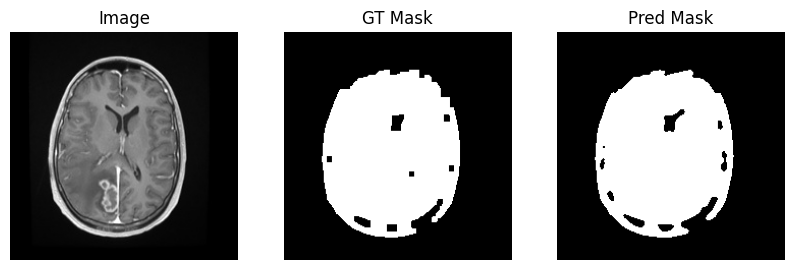

In [44]:
plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.title("Image")
plt.imshow(imgs[0][0].cpu(), cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("GT Mask")
plt.imshow(masks[0], cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Pred Mask")
plt.imshow(preds[0][0].cpu(), cmap="gray")
plt.axis("off")

plt.show()


In [47]:
import torch

def dice_score(pred, target, eps=1e-7):
    pred = pred.float()
    target = target.float()
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2 * intersection + eps) / (union + eps)
    return dice.mean().item()

def iou_score(pred, target, eps=1e-7):
    pred = pred.bool()
    target = target.bool()

    intersection = (pred & target).sum(dim=(1,2,3))
    union = (pred | target).sum(dim=(1,2,3))

    return ((intersection + eps) / (union + eps)).mean().item()


In [48]:
model.eval()

dice_scores = []
iou_scores = []

with torch.no_grad():
    for imgs, masks in loader:
        imgs = imgs.to(device)
        masks = masks.to(device).unsqueeze(1)

        preds = model(imgs)
        preds = torch.sigmoid(preds)
        preds = (preds > 0.5)

        dice_scores.append(dice_score(preds, masks))
        iou_scores.append(iou_score(preds, masks))

print(f"Mean Dice Score: {sum(dice_scores)/len(dice_scores):.4f}")
print(f"Mean IoU Score : {sum(iou_scores)/len(iou_scores):.4f}")


Mean Dice Score: 0.9679
Mean IoU Score : 0.9391


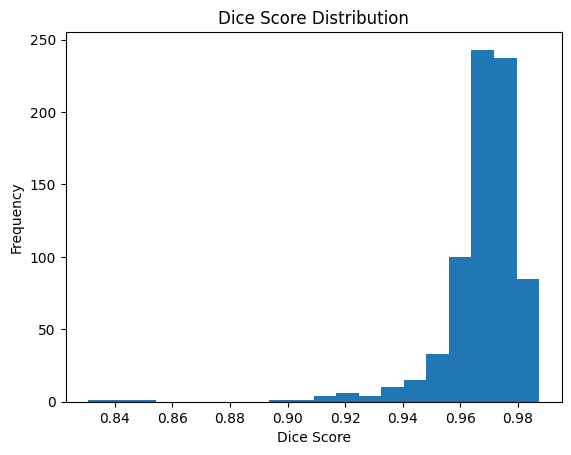

In [50]:
plt.hist(dice_scores, bins=20)
plt.xlabel("Dice Score")
plt.ylabel("Frequency")
plt.title("Dice Score Distribution")
plt.show()


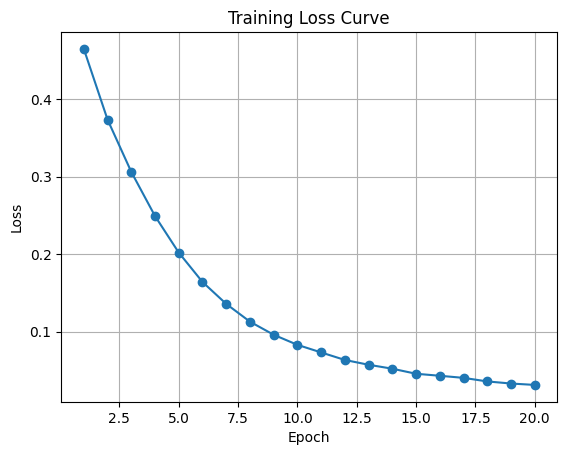

In [51]:
train_losses = [
    0.4646, 0.3734, 0.3060, 0.2490, 0.2019,
    0.1640, 0.1357, 0.1128, 0.0959, 0.0829,
    0.0731, 0.0634, 0.0572, 0.0521, 0.0456,
    0.0430, 0.0403, 0.0357, 0.0330, 0.0312
]

plt.plot(range(1,21), train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.show()
